In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

In [2]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reweighting a Gaussian Distribution

## Step 1

Suppose we have two Gaussian distributions, $\mathcal{N}_{0}(\mu_{0}, \sigma)$ and $\mathcal{N}_{1}(\mu_{1}, \sigma)$. Our goal is to transform $\mathcal{N}_{0}$ into $\mathcal{N}_{1}$. We attempt to calculate weights using a neural network $f(x)$ that has been trained to classify between $x_{0} \in \mathcal{N}_{0}(\mu_{0}, \sigma)$ and assign it the label 0, and $x_{1} \in \mathcal{N}_{1}(\mu_{1}, \sigma)$ and assign it the label 1.

Then the weights are calculated as;


$$
w = \frac{f(x)}{1 - f(x)}
$$

Let's define a neural network with 2 hidden layers, each consisting of 20 nodes. All the hidden layers will be activated using the `ReLU` activation function, and the final output layer will be activated using the `Sigmoid` activation function.

In [3]:
class GaussClassifier(nn.Module):
    def __init__(self, input_dim: int = 1, output_dim: int = 1, hidden_dim: int = 20):
        super(GaussClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim, bias=True)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.fc4 = nn.Linear(hidden_dim, output_dim, bias=True)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

Let's create some data samples. Here $x_{0} \in \mathcal{N}_{0}(0, 1)$ and $x_{1} \in \mathcal{N}_{1}(1, 1)$.

In [4]:
n_data_points = 10**5

batch_size = 1000

mu_0 = 0.
mu_1 = 1.
sigma_0 = 1.
sigma_1 = 1.

In [5]:
X0 = np.random.normal(mu_0, sigma_0, n_data_points)
X1 = np.random.normal(mu_1, sigma_1, n_data_points)

Y0 = np.zeros(n_data_points)
Y1 = np.ones(n_data_points)

X = np.concatenate((X0, X1)).reshape(-1, 1)
Y = np.concatenate((Y0, Y1)).reshape(-1, 1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, shuffle=True)

In [6]:
# Convert data to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
Y_train_tensor = torch.from_numpy(Y_train).float()

X_test_tensor = torch.from_numpy(X_test).float()
Y_test_tensor = torch.from_numpy(Y_test).float()


# Create PyTorch datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
# Create the model
model = GaussClassifier(hidden_dim = 20)

Let's use the `BCELoss` function to calculate the loss and the `Adam` optimizer for backpropagation.

In [8]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [9]:
# Move the model to GPU if available
model = model.to(device=device)

In [10]:
# Model summary
print("using device : {}".format(device))
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(model)
print('total trainable params: {}'.format(total_trainable_params))

using device : cpu
GaussClassifier(
  (fc1): Linear(in_features=1, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)
total trainable params: 901


Let's define the training step and reweighting functions. Additionally, we will utilize early stopping to reduce the risk of overfitting.

In [11]:
def train_model(model, train_loader, test_loader, criterion, optimizer, device, epochs, early_stopping_patience):
    best_loss = float('inf')
    best_model_weights = None
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_inputs, batch_labels in train_loader:
            batch_inputs = batch_inputs.to(device)
            batch_labels = batch_labels.to(device)

            optimizer.zero_grad()
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_labels)

            loss.backward()
            optimizer.step()
            running_loss += loss.item() * batch_inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        # Evaluation
        model.eval()
        with torch.no_grad():
            running_loss = 0.0
            for batch_inputs, batch_labels in test_loader:
                batch_inputs = batch_inputs.to(device)
                batch_labels = batch_labels.to(device)

                outputs = model(batch_inputs)
                loss = criterion(outputs, batch_labels)

                running_loss += loss.item() * batch_inputs.size(0)

            validation_loss = running_loss / len(test_loader.dataset)

            print("Epoch {}: Train Loss = {:.4f}, Test Loss = {:.4f}".format(epoch + 1, epoch_loss, validation_loss))

            # Check for early stopping
            if validation_loss < best_loss:
                best_loss = validation_loss
                best_model_weights = model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= early_stopping_patience:
                print("Early stopping at epoch {}".format(epoch))
                break

    return best_model_weights

In [12]:
def reweight_fn(model, X_val):
    # Move the model to CPU for evaluation
    model = model.to(torch.device("cpu"))

    model.eval()
    with torch.no_grad():
        preds = model(torch.Tensor(X_val)).detach().numpy().ravel()
        weights = preds / (1.0 - preds)
    return weights

Let's train the classifier and calculate the weights.

In [13]:
epochs = 200
early_stopping_patience = 10

# Compile the train function
opt_train = torch.compile(train_model, mode="max-autotune")

best_model_weights = opt_train(model, train_loader, test_loader, criterion, optimizer, device, epochs, early_stopping_patience)

Epoch 1: Train Loss = 0.6861, Test Loss = 0.6798
Epoch 2: Train Loss = 0.6723, Test Loss = 0.6633
Epoch 3: Train Loss = 0.6530, Test Loss = 0.6421
Epoch 4: Train Loss = 0.6316, Test Loss = 0.6207
Epoch 5: Train Loss = 0.6101, Test Loss = 0.5998
Epoch 6: Train Loss = 0.5934, Test Loss = 0.5891
Epoch 7: Train Loss = 0.5865, Test Loss = 0.5850
Epoch 8: Train Loss = 0.5838, Test Loss = 0.5831
Epoch 9: Train Loss = 0.5826, Test Loss = 0.5822
Epoch 10: Train Loss = 0.5820, Test Loss = 0.5817
Epoch 11: Train Loss = 0.5816, Test Loss = 0.5814
Epoch 12: Train Loss = 0.5814, Test Loss = 0.5811
Epoch 13: Train Loss = 0.5812, Test Loss = 0.5810
Epoch 14: Train Loss = 0.5811, Test Loss = 0.5809
Epoch 15: Train Loss = 0.5810, Test Loss = 0.5808
Epoch 16: Train Loss = 0.5810, Test Loss = 0.5808
Epoch 17: Train Loss = 0.5809, Test Loss = 0.5807
Epoch 18: Train Loss = 0.5809, Test Loss = 0.5807
Epoch 19: Train Loss = 0.5809, Test Loss = 0.5807
Epoch 20: Train Loss = 0.5809, Test Loss = 0.5806
Epoch 21:

Let's validate the trained model.

In [14]:
X0_val = np.random.normal(mu_0, sigma_0, n_data_points)
X1_val = np.random.normal(mu_1, sigma_1, n_data_points)

In [15]:
# Load the best model weights
model.load_state_dict(best_model_weights)

weights = reweight_fn(model, X0_val.reshape(-1, 1))

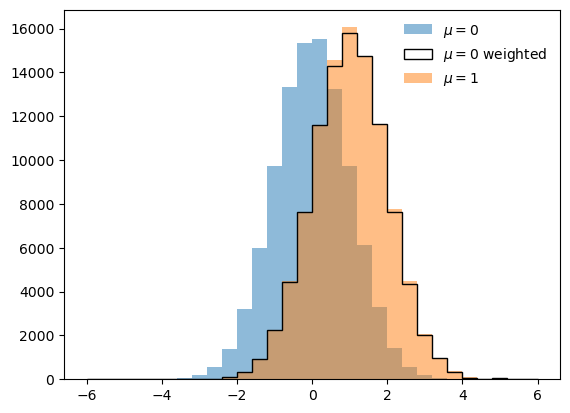

In [16]:
bins = np.linspace(-6, 6, 31)
plt.hist(X0_val, bins=bins, alpha=0.5, label=r'$\mu=0$')
plt.hist(X0_val, bins=bins, label=r'$\mu=0$ weighted', weights=weights, histtype='step', color='k')
plt.hist(X1_val, bins=bins, alpha=0.5, label=r'$\mu=1$')
plt.legend(frameon=False)
plt.show()

At this point, we have used a trained neural network to calculate the weights. In the next step, we will try to parameterize the neural network.

## Step 2

In this step, we will parameterize the neural network to calculate the weights for any $\mu$.

Let $x_{0} \in \mathcal{N}{0}(0, 1)$ with label 0, and $x{1} \in \mathcal{N}{1}(\mu, 1)$ for $\mu \in [-2, 2]$. We train the neural network to classify $x_{0}$ and $x_{1}$

In [17]:
# Create data
n_data_points = 10**5
mu_min = -2
mu_max = 2
mu_values = np.random.uniform(mu_min, mu_max, n_data_points)

X0 = [(np.random.normal(0, 1), mu) for mu in mu_values] # Note the zero in normal(0, 1)
X1 = [(np.random.normal(mu, 1), mu) for mu in mu_values]

Y0 = np.zeros(n_data_points)
Y1 = np.ones(n_data_points)

X = np.concatenate((X0, X1))
Y = np.concatenate((Y0, Y1)).reshape(-1, 1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, shuffle=True)

# Convert data to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
Y_train_tensor = torch.from_numpy(Y_train).float()

X_test_tensor = torch.from_numpy(X_test).float()
Y_test_tensor = torch.from_numpy(Y_test).float()

# Create PyTorch datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
fit_model = GaussClassifier(input_dim=2, hidden_dim=50)

In [19]:
# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(fit_model.parameters(), lr=0.001)

In [20]:
# Move the model to GPU if available
fit_model = fit_model.to(device)

In [21]:
# Model summary
print("using device : {}".format(device))
total_trainable_params = sum(p.numel() for p in fit_model.parameters() if p.requires_grad)
print(fit_model)
print('total trainable params: {}'.format(total_trainable_params))

using device : cpu
GaussClassifier(
  (fc1): Linear(in_features=2, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)
total trainable params: 5301


In [22]:
# Training loop
epochs = 200
early_stopping_patience = 10

# Compile
opt_train = torch.compile(train_model, mode="max-autotune")

best_model_weights = opt_train(fit_model, train_loader, test_loader, criterion, optimizer, device, epochs, early_stopping_patience)

Epoch 1: Train Loss = 0.6013, Test Loss = 0.5660
Epoch 2: Train Loss = 0.5654, Test Loss = 0.5645
Epoch 3: Train Loss = 0.5645, Test Loss = 0.5633
Epoch 4: Train Loss = 0.5641, Test Loss = 0.5640
Epoch 5: Train Loss = 0.5640, Test Loss = 0.5642
Epoch 6: Train Loss = 0.5640, Test Loss = 0.5633
Epoch 7: Train Loss = 0.5640, Test Loss = 0.5641
Epoch 8: Train Loss = 0.5639, Test Loss = 0.5633
Epoch 9: Train Loss = 0.5640, Test Loss = 0.5636
Epoch 10: Train Loss = 0.5637, Test Loss = 0.5633
Epoch 11: Train Loss = 0.5637, Test Loss = 0.5636
Epoch 12: Train Loss = 0.5636, Test Loss = 0.5632
Epoch 13: Train Loss = 0.5634, Test Loss = 0.5631
Epoch 14: Train Loss = 0.5635, Test Loss = 0.5630
Epoch 15: Train Loss = 0.5635, Test Loss = 0.5639
Epoch 16: Train Loss = 0.5633, Test Loss = 0.5630
Epoch 17: Train Loss = 0.5632, Test Loss = 0.5629
Epoch 18: Train Loss = 0.5635, Test Loss = 0.5630
Epoch 19: Train Loss = 0.5634, Test Loss = 0.5629
Epoch 20: Train Loss = 0.5632, Test Loss = 0.5632
Epoch 21:

In [23]:
# Validate

mu_1 = -1.2
assert mu_min <= mu_1 <= mu_max  # choose mu1 in valid range

X0_val = np.random.normal(0, 1, n_data_points)
X1_val = np.random.normal(mu_1, 1, n_data_points)

X_input = np.array([(x, mu_1) for x in X0_val])

# Load the best model weights
fit_model.load_state_dict(best_model_weights)

weights = reweight_fn(fit_model, X_input)

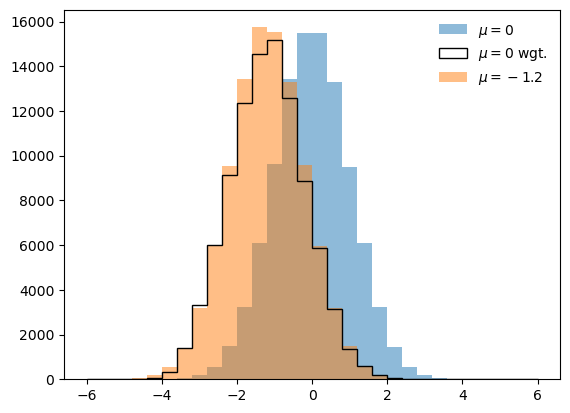

In [24]:
bins = np.linspace(-6, 6, 31)
plt.hist(X0_val, bins=bins, alpha=0.5, label=r'$\mu=0$')
plt.hist(X0_val, bins=bins, label=r'$\mu=0$ wgt.', weights=weights, histtype='step', color='k')
plt.hist(X1_val, bins=bins, alpha=0.5, label=r'$\mu={}$'.format(mu_1))
plt.legend(frameon=False)
plt.show()

Now we have parameterized the neural network to calculate the weights for any $\mu$ values. We can now use this neural network to extract the unknown parameters.

## Step 3

In this step we extract the unknown parameter by minimizing the loss using the gradient decent algorithem.

In [25]:
# Fit the model
def fit_fn(epochs, add_params_layer, fit_model, data_loader, device, optimizer, loss_fn):
    losses = []
    fit_vals = []

    for epoch in range(epochs):
        add_params_layer.train()
        running_loss = 0.0
        for batch_inputs, batch_labels in data_loader:
            batch_inputs = batch_inputs.to(device)
            batch_labels = batch_labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            output = fit_model(add_params_layer(batch_inputs))

            # Compute the loss
            loss = loss_fn(output, batch_labels)

            # Backward pass and update weights
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * batch_inputs.size(0)

        epoch_loss = running_loss / len(data_loader.dataset)
        print("epoch : {}, loss = {:.4f}, mu = {:.4f}".format(epoch + 1, epoch_loss, add_params_layer.params.item()))
        losses.append(epoch_loss)
        fit_vals.append(add_params_layer.params.item())

    return losses, fit_vals

In [26]:
# module used to add parameter for fitting
class AddParams2Input(nn.Module):
    def __init__(self, params):
        super(AddParams2Input, self).__init__()
        self.params = nn.Parameter(torch.Tensor(params), requires_grad=True)

    def forward(self, inputs):
        batch_params = torch.ones((inputs.size(0), 1), device=inputs.device) * self.params.to(device=inputs.device)
        concatenated = torch.cat([inputs, batch_params], dim=-1)
        return concatenated

In [27]:
# Create data
mu_secret = 1.3
X_mystery = np.random.normal(mu_secret, 1, n_data_points)


Y0 = np.zeros(n_data_points)
Y1 = np.ones(n_data_points)

X = np.concatenate((np.array(X0)[:,0], X_mystery)).reshape(-1, 1)
Y = np.concatenate((Y0, Y1)).reshape(-1, 1)

# Create PyTorch datasets and dataloaders
dataset = TensorDataset(torch.Tensor(X), torch.Tensor(Y).float())

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [28]:
# Load the best model weights
fit_model.load_state_dict(best_model_weights)

# Define the parameters
mu_fit_init = [0.]

# Create the AddParams2Input layer
add_params_layer = AddParams2Input(mu_fit_init)

Since we have trained the neural network to calculate the weights for any $\mu$, we can freeze the weights and biases. Now, we only need to optimize one parameter.

In [29]:
# Set all weights in fit model to non-trainable
for param in fit_model.parameters():
    param.requires_grad = False

In [30]:
# Define the loss function and optimizer
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(add_params_layer.parameters(), lr=0.0001)

In [31]:
# Transfer models to GPU
add_params_layer = add_params_layer.to(device)
fit_model = fit_model.to(device)

In [32]:
# Model summary
print("using device : {}".format(device))
fit_trainable_params = sum(p.numel() for p in fit_model.parameters() if p.requires_grad)
print(fit_model)
print('total trainable params in fit model: {}'.format(fit_trainable_params))

total_trainable_params = sum(p.numel() for p in add_params_layer.parameters() if p.requires_grad)
print(add_params_layer)
print('total trainable params in fit model: {}'.format(total_trainable_params))

using device : cpu
GaussClassifier(
  (fc1): Linear(in_features=2, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)
total trainable params in fit model: 0
AddParams2Input()
total trainable params in fit model: 1


In [33]:
# Training loop
epochs = 200

# Compile
opt_fit =  torch.compile(fit_fn, mode="max-autotune")

losses, fit_vals = opt_fit(epochs, add_params_layer, fit_model, data_loader, device, optimizer, loss_fn)

epoch : 1, loss = 0.6977, mu = 0.0199
epoch : 2, loss = 0.6913, mu = 0.0395
epoch : 3, loss = 0.6852, mu = 0.0590
epoch : 4, loss = 0.6792, mu = 0.0783
epoch : 5, loss = 0.6734, mu = 0.0974
epoch : 6, loss = 0.6678, mu = 0.1163
epoch : 7, loss = 0.6624, mu = 0.1352
epoch : 8, loss = 0.6571, mu = 0.1539
epoch : 9, loss = 0.6520, mu = 0.1725
epoch : 10, loss = 0.6470, mu = 0.1910
epoch : 11, loss = 0.6422, mu = 0.2093
epoch : 12, loss = 0.6376, mu = 0.2272
epoch : 13, loss = 0.6332, mu = 0.2450
epoch : 14, loss = 0.6290, mu = 0.2628
epoch : 15, loss = 0.6249, mu = 0.2804
epoch : 16, loss = 0.6209, mu = 0.2980
epoch : 17, loss = 0.6171, mu = 0.3155
epoch : 18, loss = 0.6133, mu = 0.3329
epoch : 19, loss = 0.6097, mu = 0.3503
epoch : 20, loss = 0.6063, mu = 0.3673
epoch : 21, loss = 0.6030, mu = 0.3842
epoch : 22, loss = 0.6000, mu = 0.4008
epoch : 23, loss = 0.5971, mu = 0.4173
epoch : 24, loss = 0.5943, mu = 0.4339
epoch : 25, loss = 0.5915, mu = 0.4506
epoch : 26, loss = 0.5888, mu = 0.

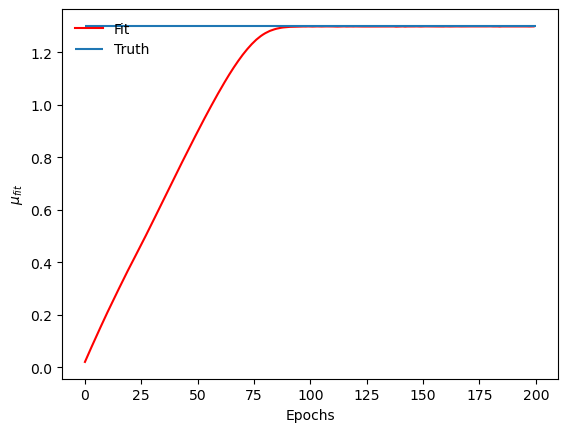

In [34]:
plt.plot(fit_vals, label='Fit', color='r')
plt.hlines(mu_secret, 0, len(fit_vals), label='Truth')
plt.xlabel("Epochs")
plt.ylabel(r'$\mu_{fit}$')
plt.legend(frameon=False)
plt.show()